# Volcanic Impact in Obs

* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton University

## Import, parameters and data

In [2]:
# import
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import geoxarray
from geoplots import mapplot
import xlearn
from climindex import get_climate_index
from geoplots import xticksmonth
import mystats as ms

!date
%matplotlib notebook

Tue Apr 17 12:21:24 EDT 2018


In [3]:
das = dict()

### CRU

In [4]:
# params
ncfile = '/tigress/wenchang/data/cru/cru_ts4.01.1901.2016.pre.dat.nc'
data_name = 'pre'
units_old = 'mm/month'
units_new = 'mm/day'
lons_sahel = slice(-20,10)
lats_sahel = slice(10,20)

year_erupt = 1963
years_avg = slice(f'{year_erupt - 5}', f'{year_erupt - 1}')
years_analysis = slice(f'{year_erupt - 1}', f'{year_erupt + 2}')
years_all = slice(f'{year_erupt -5}', f'{year_erupt + 2}')
units = 'mm/day'

In [5]:
# data
ds = xr.open_dataset(ncfile)
da = ds[data_name]
# anomaly from 5-year climtology
damean = da.sel(time=years_avg).groupby('time.month').mean('time')
daa = da.sel(time=years_analysis).groupby('time.month') - damean # anomaly
daa = daa.resample(time='MS').mean('time') \
    .sel(lon=slice(-20,50)).mean('lon') \
    .pipe(lambda x:x/30.).assign_attrs(units=units_new)

das['cru'] = daa.copy() ####

<IPython.core.display.Javascript object>


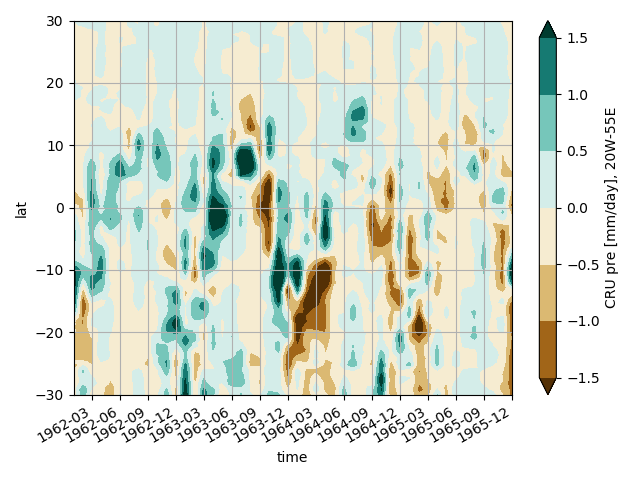

In [6]:
# longitudes: 20W-55E
daa.rename(f'CRU {data_name} [{units}], 20W-55E') \
    .plot.contourf(x='time', y='lat', robust=True, cmap='BrBG')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.ylim(-30,30)
plt.tight_layout()

### FLOR

In [7]:
from data_CTL1860 import open_ensemble as get_ctl
from data_agung import open_data as get_volcano
volcano_name = 'Agung'
year_volcano = 1963
ens = range(1,31)
nbname = 'volcano_impact_on_climate_agung.ipynb'
new_names = {'grid_xt': 'lon', 'grid_yt': 'lat'}

land_mask = xr.open_dataset('/tigress/wenchang/MODEL_OUT/PIctl_CMIP6volc/POSTP/00010101.atmos_month.nc') \
    .land_mask.rename({'grid_xt': 'lon', 'grid_yt': 'lat'})

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])


In [8]:
data_name = 'precip'
scale_factor = 3600*24

ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

da_ctl = da_ctl * scale_factor
da_volcano = da_volcano * scale_factor

Data loaded from cache/volcano_impact_on_climate_agung.ipynb.precip.ctl.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.precip.nc


In [9]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.where(land_mask>.5).where((daa.lon>=340)|(daa.lon<=55)).mean(['lon', 'en']) # zonal mean

das['flor'] = daa.copy()

<IPython.core.display.Javascript object>


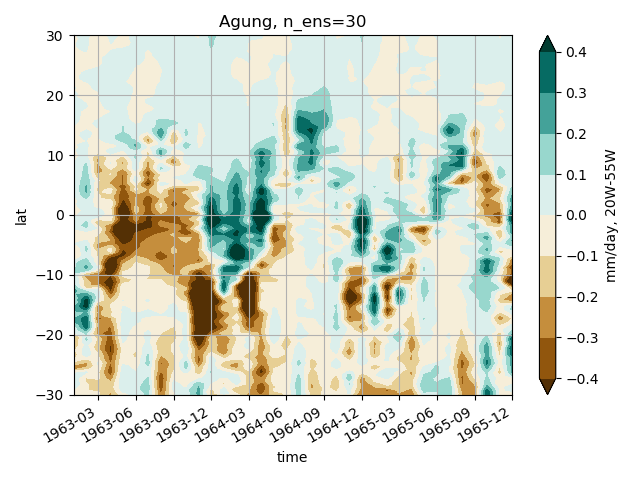

In [10]:
daa.rename('mm/day, 20W-55W').plot.contourf(x='time', y='lat', 
    levels=10, robust=True, center=0, cmap='BrBG')
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.ylim(-30,30)
plt.tight_layout()

<IPython.core.display.Javascript object>


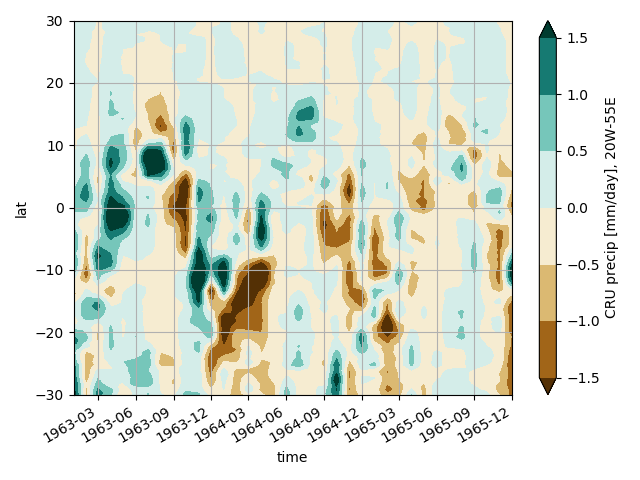

In [11]:
das['cru'].sel(time=slice('1963','1965')).rename(f'CRU {data_name} [{units}], 20W-55E') \
    .plot.contourf(x='time', y='lat', robust=True, cmap='BrBG')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.ylim(-30,30)
plt.tight_layout()

## Corr

In [12]:
tstarts = pd.date_range('1962-01', '1964-10', freq='MS')
r = np.zeros(len(tstarts))
lats = slice(-30,30)
X = das['flor'].sel(time=pd.date_range('1963-12', periods=15, freq='MS'), lat=lats)
for i,tstart in enumerate(tstarts):
    Y = das['cru'].sel(time=pd.date_range(tstart, periods=15, freq='MS'), lat=lats)
    r[i] = ms.corr(X.values.ravel(), Y.values.ravel())
da_r = xr.DataArray(r, dims=('time',), coords=(tstarts,))

<IPython.core.display.Javascript object>


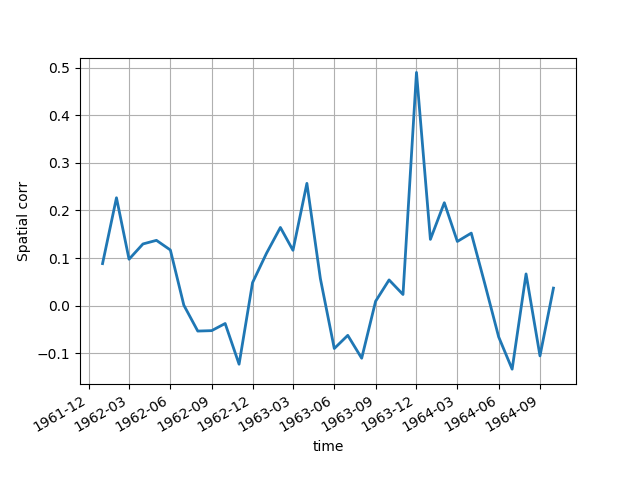

Text(0,0.5,'Spatial corr')

In [13]:
da_r.plot()
plt.grid(True)
xticksmonth(range(3,13,3))
plt.ylabel('Spatial corr')